### DSCI Final Project
Group 008 - 38: Cove Beaven, Sydney Blackwell, Talia Chan, Ryan Han

### Introduction

A surge in online multiplayer games has led to an increase in the demand for research on player behaviors and server resource management. A research project in the Computer Science department at the University of British Columbia is aiming to address this need through PlaiCraft, a Minecraft server created specifically for this purpose. In this research project, the server is used to track and analyze player behavior in order to answer critical questions that can optimize server usage and recruitment strategies for future player engagement. 

The data gathered is as follows:

`sessions.csv`: Contains information on each gaming session, 5 variables across 1,535 observations.

`players.csv`: Provides demographic and attribute data for each player, 9 variables across 96 observations.

- `hashedEmail` (String): An anonymized version of the player’s email. A possible error is that there are duplicate sessions for the same user.
- `start_time`, `end_time` (DateTime): The start and end of each session (format: DD/MM/YYYY HH). The times don't account for timezones which may be a potential error, especially if users are located in different regions.
- `original_start_time`, `original_end_time` (Numeric): Unix timestamps for start and end of session. The number of digits given is not specific enough to get any difference between the two columns.
  
- `experience` (Categorical): Player’s experience level. Self reported and might not be accurate of actual experience, which might skew results with regards to experience level.
- `subscribe` (Boolean): Indicates if the payer is subscribed to Plaicrafts emails.
- `hashedEmail` (String): Coded value identifying the players email.
- `played_hours` (Numeric): The total hours played by the player.
- `gender` (Categorical): Player’s self identified gender.
- `age` (Numeric): Player's age.
- `individualId`, `organizationName` (String): No data, does not provide insight.

In this analysis we will be attempting to determine how to use player demographics to predict what 'type' of players will contribute the greatest time on the server, and therefore the most data. We will be exploring this question by analyzing the data with the following questions in mind:

Question 1: Which player demographics (age, subscription, gender, playtimes) are the best predictors for the highest session count per player?

Question 2: Through visualizations it is shown that players who have subscribed to PlaiCraft's email updates have much longer play time than whose who are not subscribed, and therefore contribute more data. How can we use the categorical variables `experience`, `gender`, as well as a newly created variable for age: `age_categories`, to predict the categorical variable `subscribe`, from which we can predict a great or small contribution to the data.

The response variables for our two questions will be the session count per player and subscriber status, respectively. The explanatory variables used will include: age, gender, experience, subscription status, and total play time. 

The response variable is the total session count (which will be calculated from `start_time` and `end_time` variables). The session count serves as a measure of player engagement and activity on the platform over time, capturing how often a player returns, which is an indicator of their interest and possible satisfaction with the game. The chosen explanatory variables — age, gender, experience, subscription status, and total play time — are likely to influence the response variable due to their inherent connection to gaming behaviour and engagement patterns. Age can reflect differences in gaming preferences and time availability, gender might influence engagement patterns due to differences in gaming preference, experience is an indicator of familiarity with the game and gaming, subscription status can be an indicator for the level of engagement, and total play time has possibilities of being directly related to session count. 

The goal will be to identify which of these variables (representing demographics in combination), show the strongest correlation with the number of sessions per player.

### Methods and Results

The first step is to load in the required models for analysis:

In [16]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(cowplot)
options(repr.matrix.max.rows = 6)

Next, the data is imported and read.

In terms of wrangling, the two datasets should be merged using hashedEmail, and use group_by and summarize to give the session count for each player. From here, visualizations representing the relationship between reponse and explanatory variables can be made

In [17]:
# URLs for data
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

# Reading the data
players <- read_csv(players_url)
sessions <- read_csv(sessions_url)

# Merging datasets on hashedEmail
combined_data <- merge(sessions, players, by = "hashedEmail")

# Selecting columns needed for analysis
filtered_data <- combined_data |>
  select(hashedEmail, start_time, end_time, age, gender, experience, subscribe, played_hours)   

# Grouping by player and calculating the total number of sessions
session_counts <- filtered_data |>
  group_by(hashedEmail) |>
  summarize(sessionsCount = n())

# Merging session counts with filtered data
player_session_data <- merge(session_counts, filtered_data, by = "hashedEmail")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Visualizations for Question 1:

Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”
Warning message:
“The shape palette can deal with a maximum of 6 discrete values because more
than 6 becomes difficult to discriminate
ℹ you have requested 7 values. Consider specifying shapes manually if you need
  that many have them.”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”


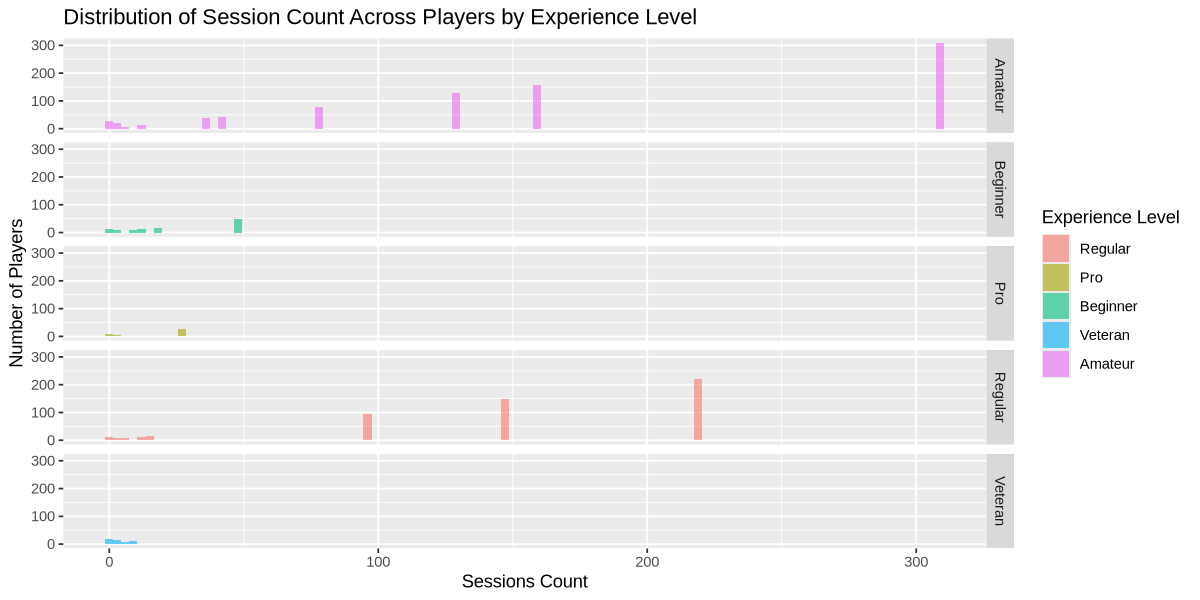

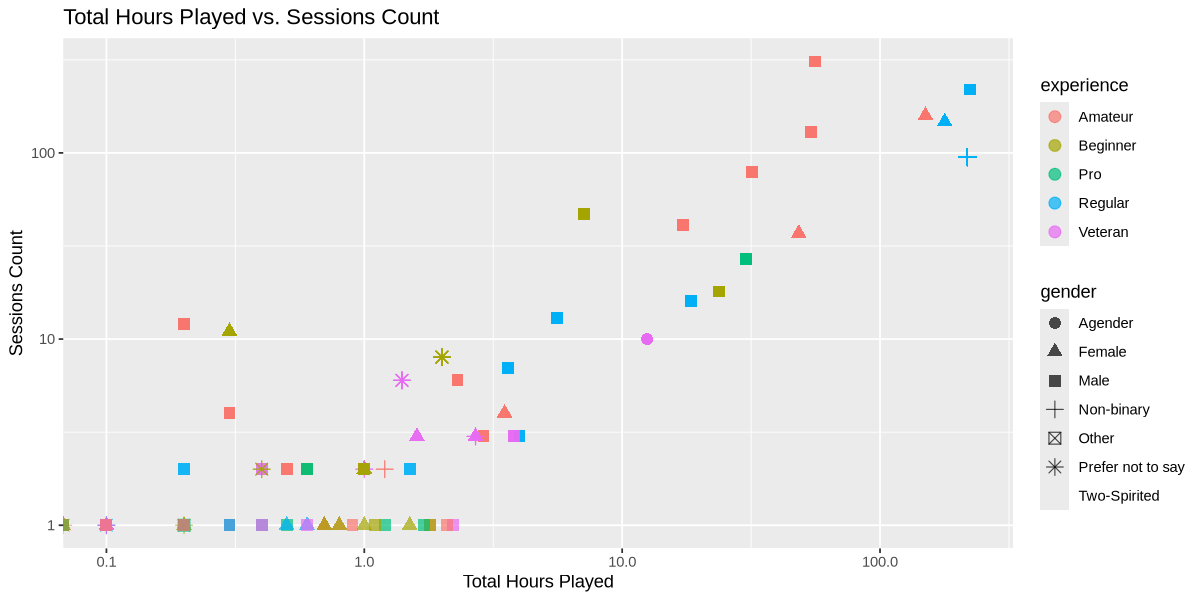

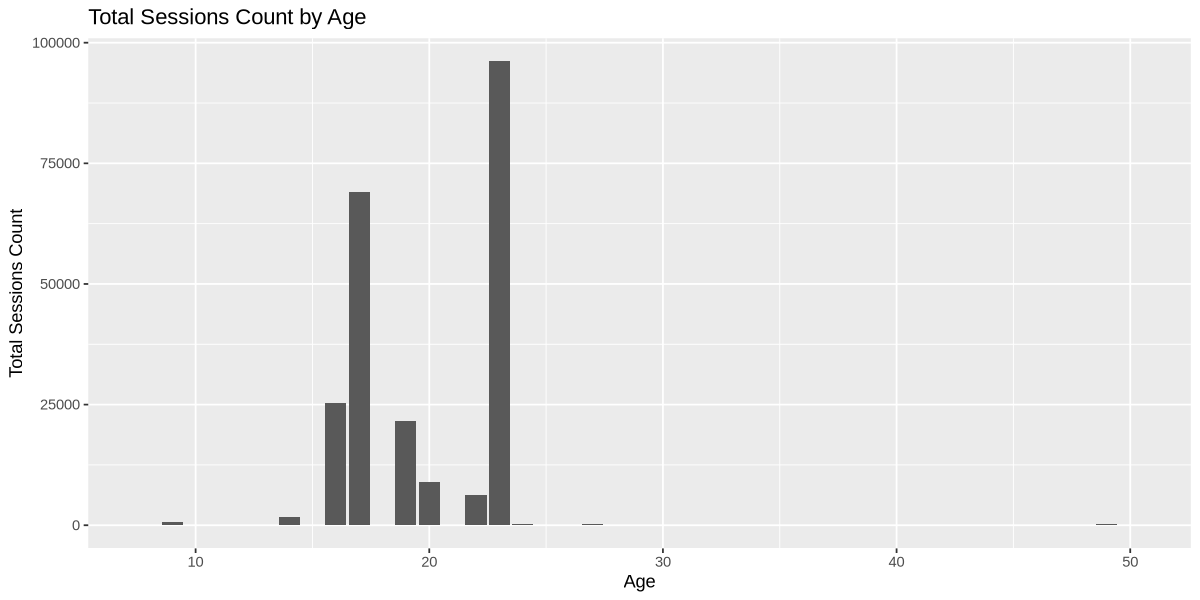

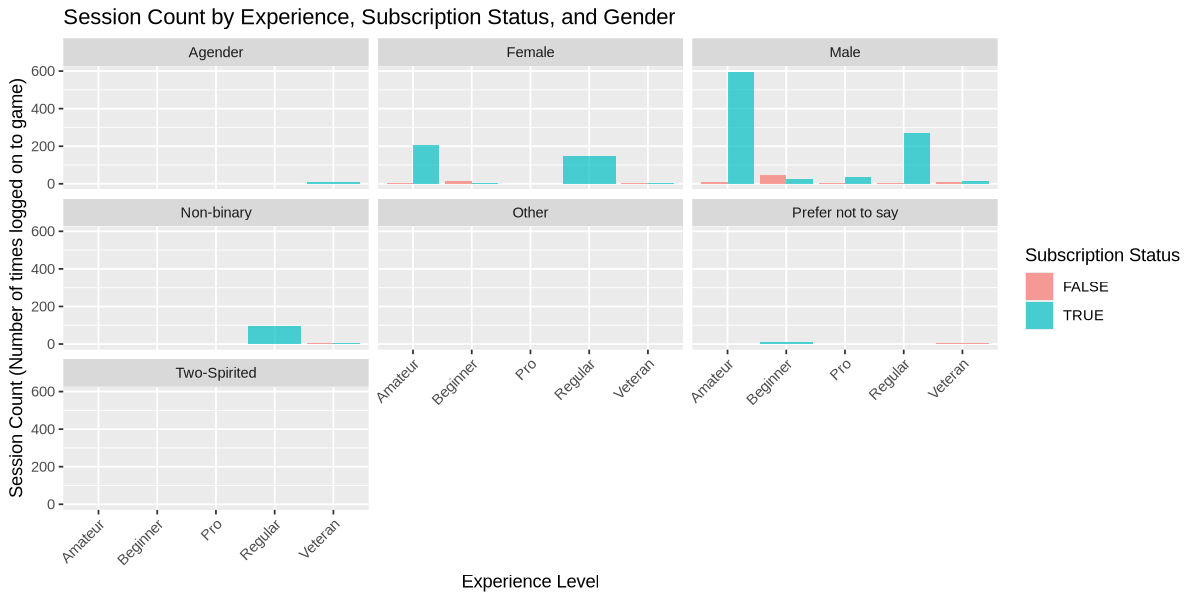

In [18]:
# Histogram session count distribution, split by experience level
session_hist <- ggplot(player_session_data, aes(x = sessionsCount, fill = as_factor(experience))) +
  geom_histogram(binwidth = 3, alpha = 0.6, position = "identity") +
  labs(title = "Distribution of Session Count Across Players by Experience Level",
       x = "Sessions Count",
       y = "Number of Players",
       fill = "Experience Level") +
  facet_grid(rows = vars(experience)) 

# Scatterplot of total hours played vs session count by experience and gender
session_hours_scatterplot <- ggplot(player_session_data, aes(x = played_hours, y = sessionsCount, color = experience, shape = gender)) +
  geom_point(size = 3, alpha = 0.7) +
  labs(title = "Total Hours Played vs. Sessions Count",
       x = "Total Hours Played",
       y = "Sessions Count") +
  scale_x_log10(labels = label_comma()) +
  scale_y_log10(labels = label_comma())

# Bar plot of total sessions count by age filtered for ages below 60
age_session_barplot <- player_session_data |> 
  filter(age < 60) |>
  ggplot(aes(x = age, y = sessionsCount)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Sessions Count by Age",
       x = "Age",
       y = "Total Sessions Count") 

#Session Count by Age, Gender, and Experience Demographics

dem_bar_plot <- ggplot(player_session_data, aes(x = experience, fill = factor(subscribe))) + 
  geom_bar(position = "dodge", color = NA, alpha = 0.7) +
  facet_wrap(~ gender) +
  labs(title = "Session Count by Experience, Subscription Status, and Gender", 
       x = "Experience Level", y = "Session Count (Number of times logged on to game)", fill = "Subscription Status")+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

session_hist
session_hours_scatterplot
age_session_barplot
dem_bar_plot

From the vizualizations, we can draw the following conclusions: 
- There is a positive linear relationship between total hours played and total sessions 
- Lots of amateaur players that have high session counts 
- Age 15-25 has the most total sessions by a significant amount; age 23 has the most play counts.
- Subscribed ammature males had the highest session count, overall more session counts by those subscribed.

We can explore a more thorough relationship of the variables with sessionsCount using a ggplairs plot:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


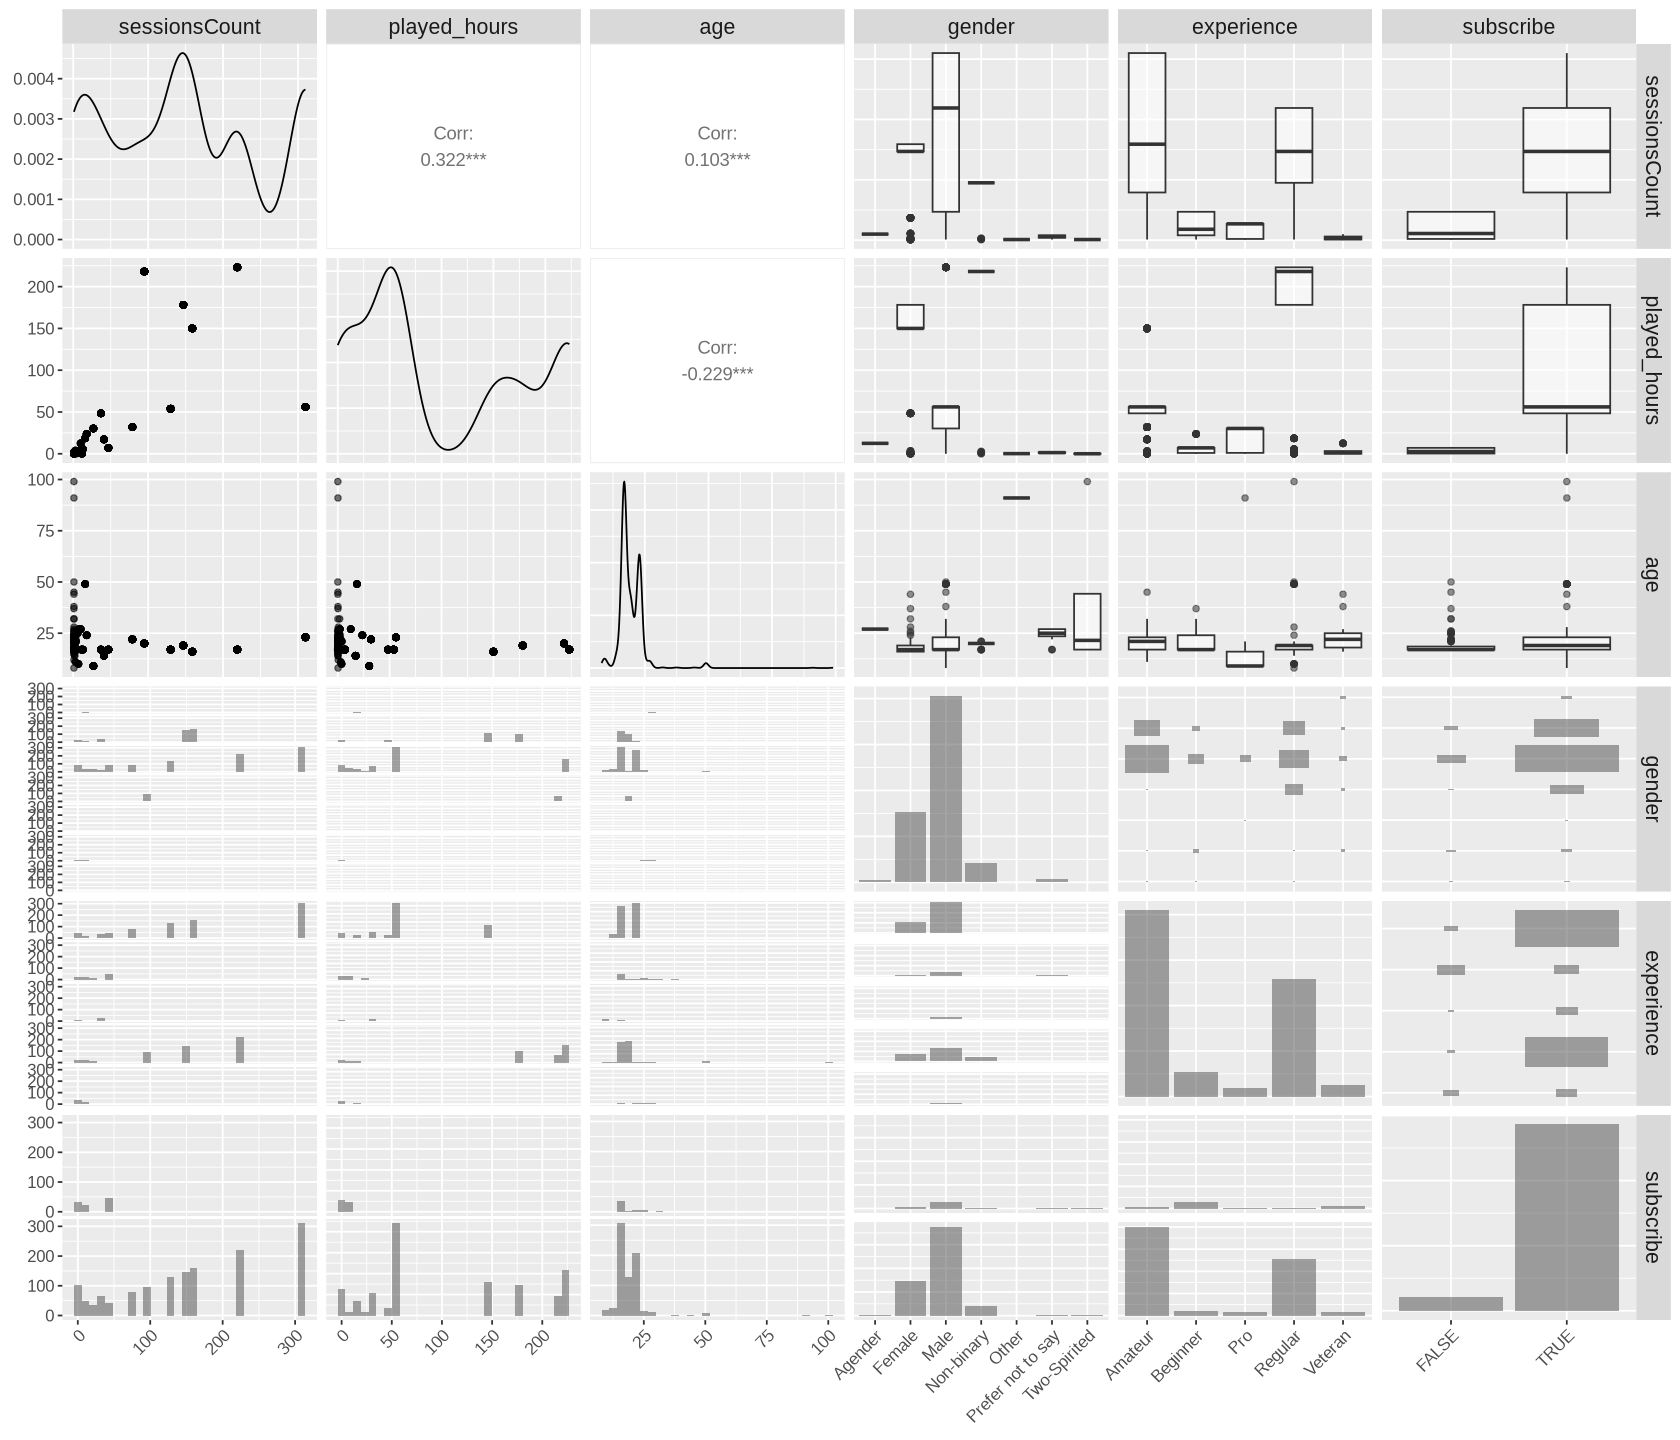

In [19]:
# Set categorical variables as factors
ggpairs_data <- player_session_data |>
  mutate(
    gender = as.factor(gender),
    experience = as.factor(experience),
    subscribe = as.factor(subscribe)
  ) |>
  select(sessionsCount, played_hours, age, gender, experience, subscribe)


options(repr.plot.width = 14, repr.plot.height = 12)

pair_plot <- ggpairs_data |> 
  ggpairs(mapping = aes(alpha = 0.4)) +
  theme(
    text = element_text(size = 16),  # Adjust overall text size
    axis.text.x = element_text(size = 10, angle = 45, hjust = 1),  # Rotate x-axis labels for readability
    axis.text.y = element_text(size = 10)  # Reduce y-axis text size
  )

pair_plot

#### Modelling for Question 1:

We can draw further conclusions with subscription status and gender:
- There is a significant increase in session count if players are subscribed
- Although high in variance, males have a higher session count average

Thus, the visualizations affirm that there are potential relationships between the explanatory variables and the response variable. By performing multivariate linear regression, to calculate the RMSE, which represents the average magnitude of the prediction error. The data will be split into an 80-20 training and testing set.

In [20]:
set.seed(10)

# Prepare data
player_session_data <- player_session_data |>
  mutate(gender = as.factor(gender), 
         experience = as.factor(experience), 
         subscribe = as.factor(subscribe))

# Split into training and testing sets

data_split <- initial_split(player_session_data, prop = 0.8)
train_data <- training(data_split)
test_data <- testing(data_split)


# Recipe for linear regression
lm_recipe <- recipe(sessionsCount ~ age + gender + experience + subscribe + played_hours, data = train_data) 

# Linear regression model specification
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# Combine into workflow and fit the model
lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = train_data)

# Predict and calculate RMSE
lm_test_results <- lm_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = sessionsCount, estimate = .pred)

lm_test_results

sd_sessionsCount <- player_session_data |> pull(sessionsCount) |> sd()
sd_sessionsCount

.metric .estimator .estimate 
1 rmse    standard   69.4165501
2 rsq     standard    0.5271735
3 mae     standard   54.5111452

[1] 104.1737

The RMSE is 69.41, meaning on average, the model's predictions for sessions count are off by about 69.41 sessions. Given the standard deviation of sessionsCount is 104.17, this is a relatively accurate model. We can try predicting a sessionCount now that the model's efficiency is verified, using the visualizations to see what values of each variable result in the highest session count. 

In [21]:
# Extract model coefficients
coeffs <- lm_fit |>
  extract_fit_parsnip() |>
  tidy()

# View the coefficients
coeffs

# Create a new data frame with ideal values for each predictor
new_data <- tibble(
  age = 23,  
  gender = "Male",  
  experience = "Amateur",  
  subscribe = "TRUE",  
  played_hours = 10  
)

predicted_sessions <- lm_fit |>
  predict(new_data)

predicted_sessions


term              estimate    std.error  statistic  p.value      
1  (Intercept)       -119.501388 31.7748365 -3.7608813 1.773826e-04 
2  age                  7.152956  0.4572304 15.6440939 2.148860e-50 
3  genderFemale         4.185852 26.6651603  0.1569783 8.752880e-01 
⋮  ⋮                 ⋮           ⋮          ⋮          ⋮            
12 experienceVeteran -88.228924  12.8219795 -6.8810688  9.495046e-12
13 subscribeTRUE       8.974037   9.8008319  0.9156403  3.600374e-01
14 played_hours        1.250118   0.0429936 29.0768424 1.677483e-141

.pred   
1 162.7276

Thus, the model predicted a session count for a 23 year old, male, amateur level, subscribed player with 10 hours of experience to have 162 tallied session counts with an RMSE of 69.41. The RMSE being smaller than the standard deviation of the data suggests that the model is capturing some of the key patterns, but there's still significant room for improvement. Moving forward, Plaicraft should aim to incorporate more numeric variables rather than categorical ones such that a more comprehensive analysis can be made to predict session count. Subscription status showed significant differences in session count, and Plaicraft should aim to have more of their users subscribed if they wish for an increase in session count. This observation will be expanded upon in question 2.

#### Visualizations for Question 2:
To begin exploring our second question, we need to wrangle our data further starting with the original players data set. We will create 5 categories for our ages, and then convert all of our variables into categorical variables to proceed with the analysis and modelling. We will remove all of the variables that will not be used. Then we will visualize our all of our predictors and subscribe against played_hours to assess how the time played on the server changes with each demographic.

In [22]:
players_data <- players |>
    filter(played_hours > 0) |> # only include players who have logged hours on the server
    mutate(age_categories = cut(age, 
                      breaks = c(0, 18, 35, 50, 65, Inf), 
                      labels = c("0-18", "19-35", "36-50", "51-65", "66+"), 
                      right = TRUE)) |> # sort age into categories
    mutate(experience = as.factor(experience),
        gender = as.factor(gender),
        subscribe = as.factor(subscribe),
        subscribe = recode(subscribe,
                            'TRUE' = 'Subscribed',
                            'FALSE' = 'Unsubscribed')) |> # change variables into categorical and rename subscribe values
    select(-hashedEmail, - individualId, -organizationName, - name, -age) # remove variables that will not be used
           
players_data

experience subscribe    played_hours gender age_categories
1   Pro        Subscribed   30.3         Male   0-18          
2   Veteran    Subscribed    3.8         Male   0-18          
3   Amateur    Subscribed    0.7         Female 19-35         
⋮   ⋮          ⋮            ⋮            ⋮      ⋮             
109 Veteran    Unsubscribed 0.3          Male   19-35         
110 Amateur    Unsubscribed 2.3          Male   0-18          
111 Pro        Subscribed   0.2          Other  66+

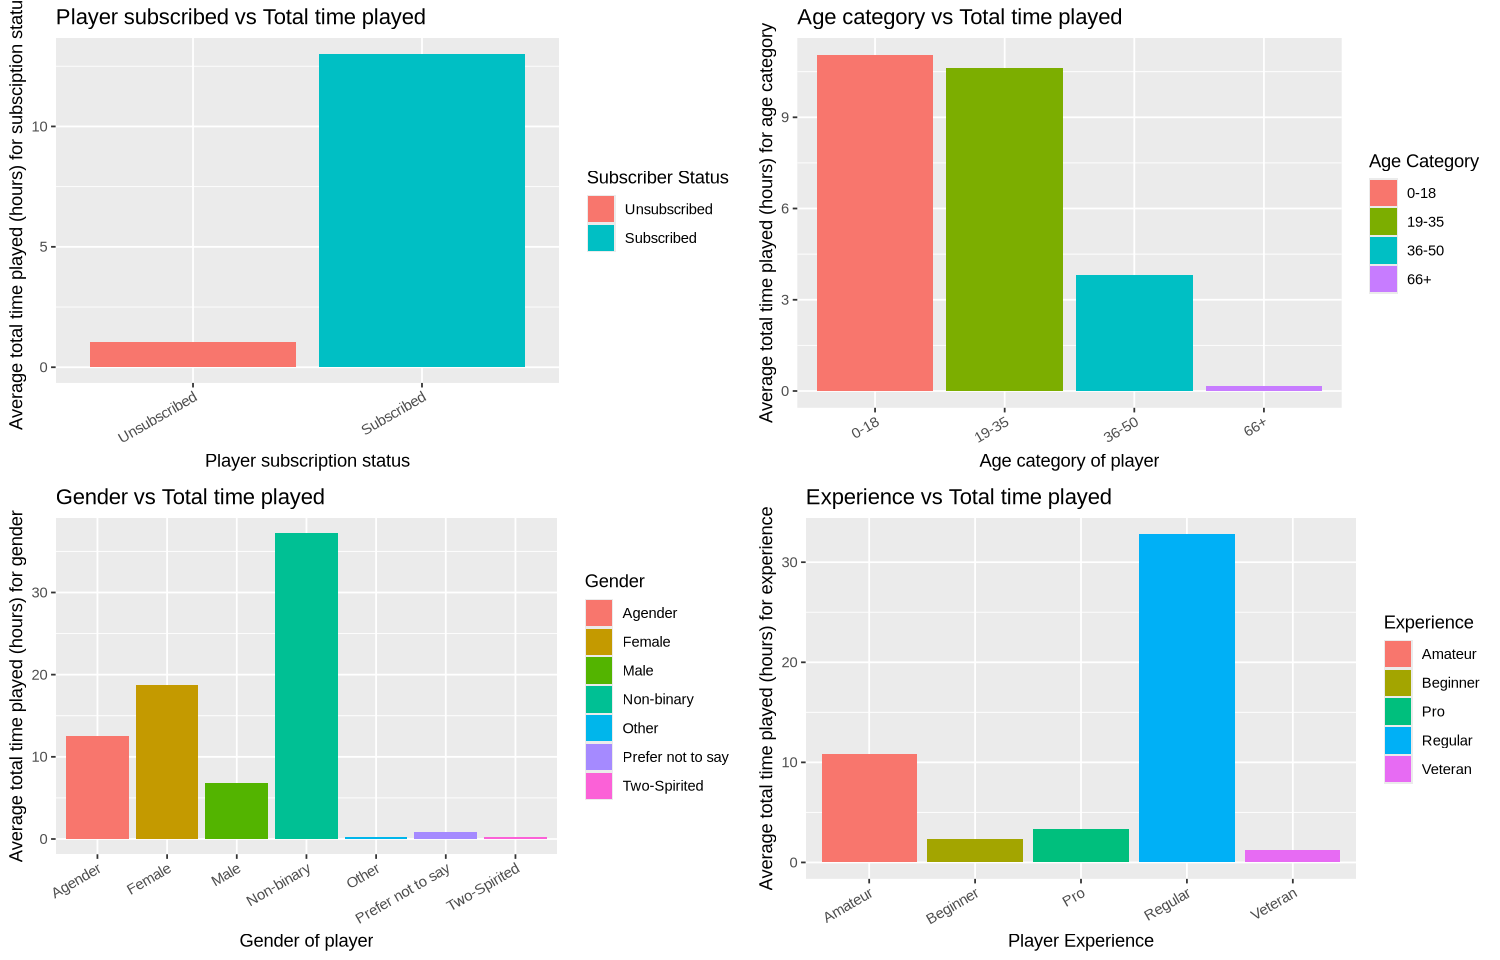

In [23]:
# create some exploratory visualizations for predicting played hours
options(repr.plot.width = 12.5, repr.plot.height = 8)

# histogram to visualize player subscribed status vs total time played
subscribe_plot <- players_data |>
    group_by(subscribe) |>
    summarize(played_hours = mean(played_hours)) |>
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_bar(stat = 'identity') +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    labs(x = 'Player subscription status', 
         y = 'Average total time played (hours) for subsciption status', 
         title = 'Player subscribed vs Total time played',
         fill = 'Subscriber Status')

# histogram to visualize player age category vs total time played
age_cat_plot <- players_data |>
    group_by(age_categories) |>
    summarize(played_hours = mean(played_hours)) |>
    ggplot(aes(x = age_categories, y = played_hours, fill = age_categories)) +
    geom_bar(stat = 'identity') +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    labs(x = 'Age category of player', 
         y = 'Average total time played (hours) for age category', 
         title = 'Age category vs Total time played', 
         fill = 'Age Category')

# histogram to visualize player gender vs total time played
gender_plot <- players_data |>
    group_by(gender) |>
    summarize(played_hours = mean(played_hours)) |>
    ggplot(aes(x = gender, y = played_hours, fill = gender)) +
    geom_bar(stat = 'identity') +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    labs(x = 'Gender of player', 
         y = 'Average total time played (hours) for gender', 
         title = 'Gender vs Total time played', 
         fill = 'Gender')

# histogram to visualize player experience vs total time played
experience_plot <- players_data |>
    group_by(experience) |>
    summarize(played_hours = mean(played_hours)) |>
    ggplot(aes(x = experience, y = played_hours, fill = experience)) +
    geom_bar(stat = 'identity') +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    labs(x = 'Player Experience', 
         y = 'Average total time played (hours) for experience', 
         title = 'Experience vs Total time played', 
         fill = 'Experience')

cat_plots <- plot_grid(subscribe_plot, age_cat_plot, gender_plot, experience_plot)
cat_plots

By creating some graphs to visualize the distribution of `played_hours` as a function of several categorical variables, we can see many differing trends in what variables contribute to high numbers of `played_hours`. I propose to use the `subscribe` variable as a proxy for predicting the demographics of players who contribute the most data to the server, ie those who contribute the most played hours.

#### Modelling for Question 1:
This will be done using the 'k-nearest neighbors' classification algorythm, which assumes little about the data set, allowing us to apply it to many data sets, including the data in question. The data will be split into training (80%) and testing (20%) sets. The value of k will be selected by maximizing the accuracy via a 5 fold cross-validation set. Then the model will be testing with the testing set and the prediction accuracy will be determined.

[1] 7

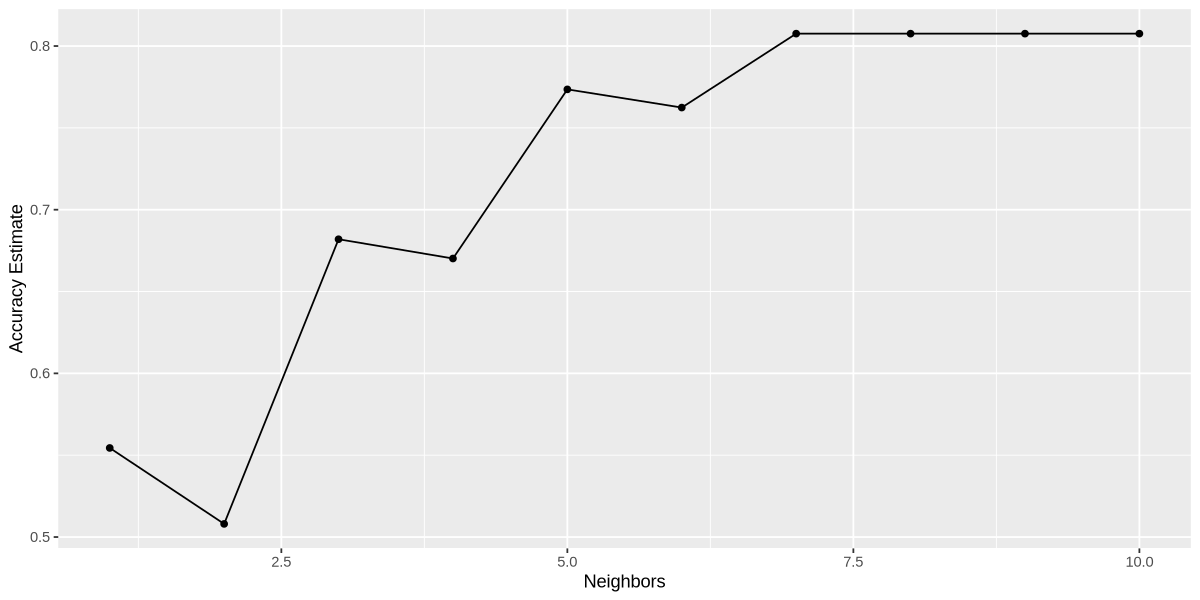

In [24]:
options(repr.plot.width = 10, repr.plot.height = 5)
set.seed(69)

# Split into training and testing sets

data_split <- initial_split(players_data, prop = 0.8)
train_data <- training(data_split)
test_data <- testing(data_split)


# Recipe for knn classification
knn_recipe <- recipe(subscribe ~ age_categories + gender + experience, data = train_data)

# knn classification model specification
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# create list of values of k to be tested
k_vals = tibble(neighbors = seq(from = 1, to = 10, by = 1))

# specify cross validation
knn_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

# Combine into workflow and fit the model
knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = knn_vfold, grid = k_vals) 

# scatterplot for 'k' number of neighbors vs accuracy
cross_val_plot <- knn_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point()  +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")

# filter for the best value of k
best_k = knn_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

cross_val_plot
best_k

We can see from the cross validation that the best value for k is at k = 7. This value will be used to test the model with the testing set to retrieve an accuracy measurement for our model.

In [25]:
# specifications for knn classification model
sub_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

# knn classification model
sub_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(sub_spec) |>
  fit(data = test_data)

sub_fit

# Predict and calculate accuracy
sub_predictions <- sub_fit |>
    predict(test_data) |>
    bind_cols(test_data) 

sub_predictions

# collect test results
sub_test_results <- sub_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == 'accuracy')

sub_test_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4782609
Best kernel: rectangular
Best k: 7

.pred_class  experience subscribe    played_hours gender age_categories
1  Subscribed   Pro        Subscribed   30.3         Male   0-18          
2  Subscribed   Regular    Subscribed    0.1         Male   19-35         
3  Subscribed   Regular    Subscribed    0.6         Male   19-35         
⋮  ⋮            ⋮          ⋮            ⋮            ⋮      ⋮             
21 Subscribed   Amateur    Subscribed   0.3          Male   0-18          
22 Unsubscribed Regular    Unsubscribed 0.1          Male   0-18          
23 Subscribed   Veteran    Unsubscribed 0.3          Male   19-35

.metric  .estimator .estimate
1 accuracy binary     0.6521739

This assessment of our model shows that the model has an accuracy of 0.65. This is relatively low, and suggests that there may be better ways to predict subscriber status, or simply that subscriber status cannot be accurately predicted from these demographic variables. Nontheless, we will try our model on a sample player to determine the predicted subscriber status based on their demographics.

In [26]:
new_player <- tibble(experience = 'Pro',
                     gender = 'Male',
                     age_categories = '19-35')

new_player_prediction <- predict(sub_fit, new_player)
new_player_prediction

.pred_class
1 Subscribed

### Discussion

The model created to answer question 1 predicted a session count for a 23 year old, male, amateur level, subscribed player with 10 hours of experience to have 162 tallied session counts with an RMSE of 69.41. The RMSE being smaller than the standard deviation of the data suggests that the model is capturing some of the key patterns, but there's still significant room for improvement. Moving forward, Plaicraft should aim to incorporate more numeric variables rather than categorical ones to enable a more comprehensive analysis of session count predictions. Subscription status showed significant differences in session count, indicating that encouraging more users to subscribe could lead to higher engagement. The model created to answer question 2 predicted that a pro, male, between ages of 19 - 15 would be subsribed. Furthermore, understanding why experience level has such a strong influence on session count is essential. Tracking hours played over time for each experience level could reveal trends in playtime and highlight how engagement evolves as players delve deeper into the game. Analyzing at which experince level players disengage could also help identify phases where session counts decline, allowing for targeted re-engagement campaigns or gameplay adjustments to improve retention.

Social engagement is another critical factor to consider. Examining the impact of in-game social features like chats, friend networks, or guilds on session counts could uncover opportunities to strengthen community-driven play. If the game records player voices during gameplay, this data could provide valuable emotional insights by analyzing tone and sentiment. Understanding how players feel during different game moments could offer actionable insights to improve player satisfaction and immersion.

A question to ask is why the experience level causes such a heavy influence on session count. Tracking hours played over time for each experience level could reveal trends in playtime and offer insights into how user engagement evolves as players spend more time with the game. Longitudinal analysis could shed light on how engagement levels vary across different stages of gameplay, providing actionable insights to improve player retention and satisfaction.

### References

Data Science
A First Introduction
Tiffany Timbers, Trevor Campbell, and Melissa Lee
2024-08-21
https://datasciencebook.ca/version-control.html#collaboration 